In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
from src.models.model import SummarizerModel, ModelWrapper
from tqdm import tqdm, trange
from transformers import get_linear_schedule_with_warmup 
from src.utils.data_preprocess import load_examples, convert_examples_to_features
from src.models.training import logger, get_train_dataloader, check_accumulation_step, get_train_batch_data, get_loss_functurn, cosine_similarity
from src.utils.constants import MINI_DIALOGSUM_PATH
from src.models.evaluate import evaluate, predict, get_eval_dataloader, get_eval_batch_data, evaluate_rouge

DEBUG:git.cmd:Popen(['git', 'version'], cwd=/home/tnguyen/dialogue-text-summarization-dokument/CODS, universal_newlines=False, shell=None, istream=None)
DEBUG:git.cmd:Popen(['git', 'version'], cwd=/home/tnguyen/dialogue-text-summarization-dokument/CODS, universal_newlines=False, shell=None, istream=None)
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
[nltk_data] Downloading package punkt to /home/tnguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from transformers import pipeline
conv =  [
"Jason: whats up? Any plan for this weekend?", 
"John: I'm thinking of go watch a movie, but not decide which yet.", 
"Debbie: What? I thought that now all the theaters are closed due to the pandamic?", 
"John: Oh! That's right. Then no idea what to do."
]

summarizer = pipeline("summarization", model="Salesforce/cods-bart-large-xsum-samsum", device=0)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /Salesforce/cods-bart-large-xsum-samsum/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140436574632648 on /home/tnguyen/.cache/huggingface/transformers/3779da8f409c6c0362f125d484851b0109552de13148a2d808b3b137fb6df52b.3dc588a59cb4425586e048c07f434f55bc79f8c047a0c4a6fb68fe6754ddc04c.lock
INFO:filelock:Lock 140436574632648 acquired on /home/tnguyen/.cache/huggingface/transformers/3779da8f409c6c0362f125d484851b0109552de13148a2d808b3b137fb6df52b.3dc588a59cb4425586e048c07f434f55bc79f8c047a0c4a6fb68fe6754ddc04c.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /Salesforce/cods-bart-large-xsum-samsum/resolve/main/config.json HTTP/1.1" 200 1510


Downloading:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140436574632648 on /home/tnguyen/.cache/huggingface/transformers/3779da8f409c6c0362f125d484851b0109552de13148a2d808b3b137fb6df52b.3dc588a59cb4425586e048c07f434f55bc79f8c047a0c4a6fb68fe6754ddc04c.lock
INFO:filelock:Lock 140436574632648 released on /home/tnguyen/.cache/huggingface/transformers/3779da8f409c6c0362f125d484851b0109552de13148a2d808b3b137fb6df52b.3dc588a59cb4425586e048c07f434f55bc79f8c047a0c4a6fb68fe6754ddc04c.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /Salesforce/cods-bart-large-xsum-samsum/resolve/main/pytorch_model.bin HTTP/1.1" 302 0
DEBUG:filelock:Attempting to acquire lock 140431575584664 on /home/tnguyen/.cache/huggingface/transformers/02d928e6493a7c380c9647abb42c0fcd3a46fd98c25a7b581e5acb75ccf00bb3.d0ec7d0ec6323d1b4588dbf9effa02274e995c428a3646fd11faffc3cab946d2.lock
INFO:filelock:Lock 140431575584664 acquired on /home/tng

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140431575584664 on /home/tnguyen/.cache/huggingface/transformers/02d928e6493a7c380c9647abb42c0fcd3a46fd98c25a7b581e5acb75ccf00bb3.d0ec7d0ec6323d1b4588dbf9effa02274e995c428a3646fd11faffc3cab946d2.lock
INFO:filelock:Lock 140431575584664 released on /home/tnguyen/.cache/huggingface/transformers/02d928e6493a7c380c9647abb42c0fcd3a46fd98c25a7b581e5acb75ccf00bb3.d0ec7d0ec6323d1b4588dbf9effa02274e995c428a3646fd11faffc3cab946d2.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /Salesforce/cods-bart-large-xsum-samsum/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /Salesforce/cods-bart-large-xsum-samsum/resolve/main/vocab.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140431540337016 on /home/tnguyen/.cac

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140431540337016 on /home/tnguyen/.cache/huggingface/transformers/d2bf8f0d9fe655ad9978633646e6fddb69d5a55e79b5da1055d6e2d718f909c0.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05.lock
INFO:filelock:Lock 140431540337016 released on /home/tnguyen/.cache/huggingface/transformers/d2bf8f0d9fe655ad9978633646e6fddb69d5a55e79b5da1055d6e2d718f909c0.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /Salesforce/cods-bart-large-xsum-samsum/resolve/main/merges.txt HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140431540404120 on /home/tnguyen/.cache/huggingface/transformers/18570ffa8ed96de3b9c6d3dc3b4ab37d59e42750a14a0bb0624151b09c3f2ddf.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
INFO:filelock:Lock 140431540404120 acquired on /home/tnguyen/.c

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140431540404120 on /home/tnguyen/.cache/huggingface/transformers/18570ffa8ed96de3b9c6d3dc3b4ab37d59e42750a14a0bb0624151b09c3f2ddf.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
INFO:filelock:Lock 140431540404120 released on /home/tnguyen/.cache/huggingface/transformers/18570ffa8ed96de3b9c6d3dc3b4ab37d59e42750a14a0bb0624151b09c3f2ddf.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /Salesforce/cods-bart-large-xsum-samsum/resolve/main/tokenizer.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /Salesforce/cods-bart-large-xsum-samsum/resolve/main/added_tokens.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggi

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140431540336456 on /home/tnguyen/.cache/huggingface/transformers/6c67b427feb7ff0cbdb0d19a0ac0021cc926e8cc94c735437d17223b988eb994.cb2244924ab24d706b02fd7fcedaea4531566537687a539ebb94db511fd122a0.lock
INFO:filelock:Lock 140431540336456 released on /home/tnguyen/.cache/huggingface/transformers/6c67b427feb7ff0cbdb0d19a0ac0021cc926e8cc94c735437d17223b988eb994.cb2244924ab24d706b02fd7fcedaea4531566537687a539ebb94db511fd122a0.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /Salesforce/cods-bart-large-xsum-samsum/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140431540373320 on /home/tnguyen/.cache/huggingface/transformers/39a5a5c6e885e7af471326d2cb9e5062a3cf1a3b82c1d73460d44c31995a446d.10366e0e2faaf644b007c4bcc1a01abaa7fedc6a66e79a4a82a7359de93c46fb.lock
INFO:filelock:Lock 140431540373320 acquired on /home

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140431540373320 on /home/tnguyen/.cache/huggingface/transformers/39a5a5c6e885e7af471326d2cb9e5062a3cf1a3b82c1d73460d44c31995a446d.10366e0e2faaf644b007c4bcc1a01abaa7fedc6a66e79a4a82a7359de93c46fb.lock
INFO:filelock:Lock 140431540373320 released on /home/tnguyen/.cache/huggingface/transformers/39a5a5c6e885e7af471326d2cb9e5062a3cf1a3b82c1d73460d44c31995a446d.10366e0e2faaf644b007c4bcc1a01abaa7fedc6a66e79a4a82a7359de93c46fb.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /Salesforce/cods-bart-large-xsum-samsum/resolve/main/modelcard.json HTTP/1.1" 404 0


In [13]:
summary_cods1 = summarizer(ctrl, min_length=10, max_length=400, num_beams=4)[0]["summary_text"]
summary_cods1

Your max_length is set to 400, but you input_length is only 351. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


"0 abstain need you to take a dictation for me 1 none 2 abstain should go out as an intra-office memorandum to all employees by this afternoon 3 none 4 abstain the use of instant message programs by employees during working hours is strictly prohibited 5 none 6 abstain apply to all communications , not only in this office between employees , but also any outside communications 7 abstain use instant messaging to communicate with their clients 8 abstain don't want any - one using instant messaging 9 abstain applies to internal and external communications 10 none 11 none 12 abstain get this memo typed up and distributed before 4 pm TLDR The new policy on instant messaging has come into effect."

In [4]:
import os
train_path = os.path.join(MINI_DIALOGSUM_PATH, 'train.json')
#train_path = 'data/processed/new_dialogsum_shuffled/train.json'
val_path = os.path.join(MINI_DIALOGSUM_PATH, 'eval.json')
test_path = os.path.join(MINI_DIALOGSUM_PATH, 'test.json')
#test_path = os.path.join('data', 'processed', 'new_dialogsum_clean_data', 'test.json')
batch_size = 1

class Args:
    do_segment = True
    #do_train = True
    output_dir='models/penalty_salesforce_5'
    use_pred_segment = False
    #train_file_path = train_path
    #dev_file_path = val_path
    test_file_path = test_path
    oracle_functurn_context = False
    source_max_len = 512
    gen_keyphrase_summary = True
    target_max_len = 50
    add_module_loss = False
    add_functurn_loss = False
    #train_batch_size = batch_size
    #gradient_accumulation_steps = 1
    #num_train_epochs = 30
    #warmup_proportion = 0.1
    #patience = 8
    #model_name = 'mini_dialogsum_1'
    #max_grad_norm = 1.0
    #validation_timing = 1
    eval_batch_size = batch_size
    no_repeat_ngram_size = 0
    beam = 4
    test_target_max_len = 50
    #wandb = False
    #learning_rate = 5e-5
    #adam_epsilon = 1e-8
    #seed = 42
    #penalty_term = 1
    #k_fold_cross_validation = False
    distributed = False
    add_name = ''
    
args = Args()

In [5]:
model_name = "Salesforce/bart-large-xsum-samsum"
#model_name = 'facebook/bart-large-xsum'
params = {
    'model_name': model_name,
    'load_path': None,
    'add_module_loss': None,
    'add_functurn_loss': None
}

model = SummarizerModel(params)
#model = ModelWrapper(args, params)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /Salesforce/bart-large-xsum-samsum/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /Salesforce/bart-large-xsum-samsum/resolve/main/pytorch_model.bin HTTP/1.1" 302 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /Salesforce/bart-large-xsum-samsum/resolve/main/vocab.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /Salesforce/bart-large-xsum-samsum/resolve/main/merges.txt HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:

In [6]:
file_path = args.test_file_path
dev_examples = load_examples(args, file_path)
#dev_features = convert_examples_to_features(args, model.module.config, model.module.tokenizer, dev_examples)
dev_features = convert_examples_to_features(args, model.config, model.tokenizer, dev_examples)

Examples: 100%|██████████| 2/2 [00:00<00:00, 157.76it/s]

[INFO] max_target_len 0


In [12]:
ctrl = dev_examples[0].context

In [5]:
#from sentence_transformers import SentenceTransformer, util
def get_similarity(dev_examples, pred):
    pred_sum_arr_p1 = []
    pred_sum_arr_p2 = []
    for d in dev_examples:
        pred_sum_arr_p1.append(pred[d.ID]['Person1'])
        pred_sum_arr_p2.append(pred[d.ID]['Person2'])
        
    return pred_sum_arr_p1, pred_sum_arr_p2
        
def similar(p1_sents, p2_sents, model):
    embeddings_p1 = model.encode(p1_sents, convert_to_tensor=True)
    embeddings_p2 = model.encode(p2_sents, convert_to_tensor=True)
    
    cosine_scores = util.cos_sim(embeddings_p1, embeddings_p2)
    
    return cosine_scores.cpu()

In [ ]:
checkpoints_dir = os.path.join('models', 'penalty_salesforce_5')

In [6]:
import re
from sentence_transformers import SentenceTransformer, util
checkpoints_dir = os.path.join('models', 'penalty_salesforce_5', 'checkpoints')
sent_embed = SentenceTransformer('all-MiniLM-L6-v2').cuda()
similarities = {}
model.cuda()
model.eval()
for file in tqdm(os.listdir(checkpoints_dir)):
    checkpoint = os.path.join(checkpoints_dir, file)
    epoch = int(re.findall('[0-9]+', file)[0])
    weights = torch.load(checkpoint)
    model.load_state_dict(weights['model_state_dict'])
    pred, pred_kp = predict(args, model, (dev_examples, dev_features))
    preds_p1, preds_p2 = get_similarity(dev_examples, pred)
    cosine_scores = similar(preds_p1, preds_p2, sent_embed)
    sims = 0
    for i in range(cosine_scores.shape[0]):
        sims += cosine_scores[i, i].item()
        
    sims /= cosine_scores.shape[0]
    similarities[epoch] = sims
    

/mnt/nkees_playground/dialogue-text-summarization-dokument/.venv/lib/python3.9/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/models/sentence-transformers/all-MiniLM-L6-v2 HTTP/1.1" 200 1609
/mnt/nkees_playground/dialogue-text-summarization-dokument/.venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:560: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:31<00:00, 15.28s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.34s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 112.68it/s]

  4%|█▌                                        | 2/53 [03:06<1:19:24, 93.42s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.27s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.36s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 118.28it/s]

  6%|██▍                                       | 3/53 [04:40<1:17:54, 93.49s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.27s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.36s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 106.29it/s]

  8%|███▏                                      | 4/53 [06:23<1:19:25, 97.25s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.49s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.59s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 128.21it/s]

  9%|███▉                                      | 5/53 [07:58<1:17:08, 96.43s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:30<00:00, 14.96s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:30<00:00, 15.03s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 118.24it/s]

 11%|████▊                                     | 6/53 [09:39<1:16:40, 97.88s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.41s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.51s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 118.31it/s]

 13%|█████▌                                    | 7/53 [11:13<1:14:12, 96.79s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.55s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.65s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 115.06it/s]

 15%|██████▎                                   | 8/53 [12:48<1:12:14, 96.33s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.34s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.42s/it]

Batches: 100%|██████████████████████████████████| 24/24 [00:00<00:00, 99.47it/s]

 17%|███████▏                                  | 9/53 [14:32<1:12:16, 98.57s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.27s/it]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.35s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 115.14it/s]

 19%|███████▋                                 | 10/53 [16:05<1:09:31, 97.02s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:30<00:00, 14.99s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:30<00:00, 15.07s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 121.17it/s]

 21%|████████▌                                | 11/53 [17:46<1:08:45, 98.23s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:30<00:00, 15.03s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the enviro

Generating: 100%|█████████████████████████████████| 6/6 [01:30<00:00, 15.10s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 112.42it/s]

 23%|█████████▎                               | 12/53 [19:28<1:07:47, 99.21s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.50s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 127.21it/s]

 25%|██████████                               | 13/53 [21:02<1:05:09, 97.75s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:29<00:00, 14.90s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 124.56it/s]

 26%|██████████▊                              | 14/53 [22:43<1:04:05, 98.59s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.56s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 129.77it/s]

 28%|███████████▌                             | 15/53 [24:18<1:01:43, 97.46s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.35s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 111.54it/s]

 30%|████████████▍                            | 16/53 [26:00<1:01:06, 99.09s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.33s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 112.93it/s]

 32%|█████████████▊                             | 17/53 [27:34<58:26, 97.41s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:30<00:00, 15.06s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:30<00:00, 15.16s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 104.92it/s]

 34%|██████████████▌                            | 18/53 [29:16<57:38, 98.81s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.42s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 104.69it/s]

 36%|███████████████                           | 19/53 [30:59<56:45, 100.18s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:31<00:00, 15.23s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:31<00:00, 15.32s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 133.25it/s]

 38%|███████████████▊                          | 20/53 [32:41<55:19, 100.59s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.61s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 129.82it/s]

 40%|█████████████████                          | 21/53 [34:16<52:45, 98.91s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.54s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.63s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 128.46it/s]

 42%|█████████████████▊                         | 22/53 [35:51<50:32, 97.83s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.65s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 122.97it/s]

 43%|██████████████████▋                        | 23/53 [37:27<48:32, 97.10s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.36s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 110.88it/s]

 45%|███████████████████▍                       | 24/53 [39:10<47:50, 99.00s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:31<00:00, 15.18s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:31<00:00, 15.26s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 121.31it/s]

 47%|███████████████████▊                      | 25/53 [40:53<46:42, 100.09s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.50s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.61s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 134.46it/s]

 49%|█████████████████████                      | 26/53 [42:28<44:22, 98.60s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.52s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.60s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 119.50it/s]

 51%|█████████████████████▉                     | 27/53 [44:03<42:16, 97.55s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:31<00:00, 15.24s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:31<00:00, 15.31s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 108.05it/s]

 53%|██████████████████████▋                    | 28/53 [45:45<41:11, 98.85s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.49s/it]

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.58s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 147.59it/s]

 55%|███████████████████████▌                   | 29/53 [47:20<39:02, 97.61s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.52s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.62s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 143.21it/s]

 57%|████████████████████████▎                  | 30/53 [48:55<37:07, 96.84s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:31<00:00, 15.24s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:31<00:00, 15.32s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 136.96it/s]

 58%|█████████████████████████▏                 | 31/53 [50:38<36:11, 98.69s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.34s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.42s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 118.51it/s]

 60%|█████████████████████████▉                 | 32/53 [52:20<34:57, 99.87s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.42s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.52s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 106.83it/s]

 62%|██████████████████████████▊                | 33/53 [53:55<32:45, 98.29s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.28s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.37s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 128.93it/s]

 64%|███████████████████████████▌               | 34/53 [55:38<31:36, 99.82s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.29s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.37s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 104.06it/s]

 66%|███████████████████████████▋              | 35/53 [57:22<30:15, 100.88s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.52s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.62s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 116.59it/s]

 68%|█████████████████████████████▏             | 36/53 [58:57<28:05, 99.17s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:29<00:00, 14.79s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:29<00:00, 14.87s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 110.97it/s]

 70%|████████████████████████████▌            | 37/53 [1:00:37<26:31, 99.45s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:31<00:00, 15.24s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:31<00:00, 15.33s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 105.72it/s]

 72%|████████████████████████████▋           | 38/53 [1:02:21<25:11, 100.80s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:31<00:00, 15.22s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 103.91it/s]

 74%|█████████████████████████████▍          | 39/53 [1:04:03<23:37, 101.25s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.58s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 132.42it/s]

 75%|██████████████████████████████▉          | 40/53 [1:05:38<21:31, 99.36s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.59s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 110.75it/s]

 77%|██████████████████████████████▉         | 41/53 [1:07:23<20:12, 101.02s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:29<00:00, 14.89s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 108.40it/s]

 79%|███████████████████████████████▋        | 42/53 [1:09:03<18:27, 100.69s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.44s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.55s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 106.24it/s]

 81%|█████████████████████████████████▎       | 43/53 [1:10:38<16:29, 98.92s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.56s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 112.61it/s]

 83%|██████████████████████████████████       | 44/53 [1:12:13<14:39, 97.70s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.55s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 109.22it/s]

 85%|██████████████████████████████████▊      | 45/53 [1:13:47<12:54, 96.81s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.32s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.40s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 104.82it/s]

 87%|███████████████████████████████████▌     | 46/53 [1:15:31<11:31, 98.83s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.31s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.38s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 126.53it/s]

 89%|████████████████████████████████████▎    | 47/53 [1:17:13<09:59, 99.85s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:28<00:00, 14.76s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:28<00:00, 14.82s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 105.67it/s]

 91%|█████████████████████████████████████▏   | 48/53 [1:18:53<08:19, 99.99s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.59s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 116.70it/s]

 92%|█████████████████████████████████████▉   | 49/53 [1:20:28<06:34, 98.50s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:30<00:00, 15.11s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 120.31it/s]

 94%|██████████████████████████████████████▋  | 50/53 [1:22:10<04:57, 99.31s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:33<00:00, 15.55s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 129.55it/s]

 96%|██████████████████████████████████████▍ | 51/53 [1:23:53<03:21, 100.54s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.29s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:32<00:00, 15.37s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 113.72it/s]

 98%|███████████████████████████████████████▏| 52/53 [1:25:36<01:41, 101.35s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Generating: 100%|█████████████████████████████████| 6/6 [01:29<00:00, 14.82s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating: 100%|█████████████████████████████████| 6/6 [01:29<00:00, 14.89s/it]

Batches: 100%|█████████████████████████████████| 24/24 [00:00<00:00, 125.75it/s]

100%|█████████████████████████████████████████| 53/53 [1:27:16<00:00, 98.81s/it]


In [7]:
import pandas as pd
f1_df = pd.read_json('f1_cos_test_metrics.json').T
f1_df = f1_df.sort_index().rename({1: 'similarity', 0: 'f1'}, axis=1)
f1_df.head()

,f1,similarity
1,0.266460,0.999887
3,0.266444,0.999260
5,0.264712,0.995657
7,0.263771,0.991066
9,0.260645,0.990532


In [8]:
f1_df.loc[49]

f1            0.229382
similarity    0.890456
Name: 49, dtype: float64

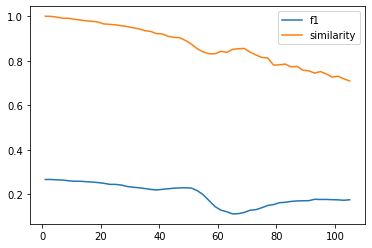

In [32]:
lines = f1_df.plot.line()

In [33]:
fig = lines.get_figure()
fig.savefig("f1_similarity.png")

In [5]:
def find_optimal_epoch(df, f1_threshold=0.20, sim_threshold=0.9):
    opt_epoch = 0
    max_diff = float("inf")
    opt_f1 = 0
    opt_sim = 0
    for i, row in df.iterrows():
        if max_diff > (abs(row['f1'] - row['similarity'])) and row['f1'] >= f1_threshold and row['similarity'] < sim_threshold:
            max_diff = abs(row['f1'] - row['similarity'])
            opt_f1 = row['f1']
            opt_sim = row['similarity']
            opt_epoch = i
    
    return opt_epoch, opt_f1, opt_sim

find_optimal_epoch(f1_df)    

NameError: name 'f1_df' is not defined

In [40]:
f1_df[f1_df['f1'] == max(f1_df['f1'])]

,f1,similarity
1,0.26646,0.999887


In [41]:
f1_df[f1_df['similarity'] == min(f1_df['similarity'])]

,f1,similarity
105,0.175315,0.709099


In [43]:
f1_df.loc[31]

f1            0.231589
similarity    0.948035
Name: 31, dtype: float64

In [ ]:
[1, 31, 49, 105]

In [62]:
f1_df.to_json('f1_sim_metrics.json')

In [6]:
model.cuda()
checkpoints_dir = os.path.join('models', 'penalty_salesforce_5')
checkpoint = os.path.join(checkpoints_dir, 'checkpoint_49.pt')

weights = torch.load(checkpoint)
model.load_state_dict(weights['model_state_dict'])
scores = evaluate(args, model, (dev_examples, dev_features), dump_pred=True)

Generating:   0%|                                         | 0/6 [00:00<?, ?it/s]/mnt/nkees_playground/dialogue-text-summarization-dokument/.venv/lib/python3.9/site-packages/transformers/generation_stopping_criteria.py:93: UserWarning: You set different `max_length` for stopping criteria and `max_length` parameter
  warnings.warn(
/mnt/nkees_playground/dialogue-text-summarization-dokument/.venv/lib/python3.9/site-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size
Generating: 100%|█████████████████████████████████| 6/6 [01:31<00:00, 15.24s/it]





rouge-1:	P: 17.0049	R: 43.0558	F1: 22.9382
rouge-2:	P: 5.9923	R: 15.3044	F1: 8.0482
rouge-3:	P: 2.9329	R: 8.0459	F1: 4.0103
rouge-4:	P: 1.4760	R: 4.3141	F1: 2.0407
rouge-l:	P: 18.9232	R: 41.9821	F1: 24.9188
rouge-w:	P: 12.7741	R: 21.3141	F1: 14.5787





In [6]:
scores

{'rouge-1': {'f': 0.21585215999246082,
  'p': 0.1624548306332973,
  'r': 0.3965837710635994},
 'rouge-2': {'f': 0.07785077023145705,
  'p': 0.05907409987050643,
  'r': 0.14399209288349424},
 'rouge-3': {'f': 0.03978412044147189,
  'p': 0.02985041774070357,
  'r': 0.0772432379143444},
 'rouge-4': {'f': 0.02060074586505667,
  'p': 0.015414395415322926,
  'r': 0.04084784697951765},
 'rouge-l': {'f': 0.23458035796771126,
  'p': 0.18044662831416589,
  'r': 0.38855928524324124},
 'rouge-w': {'f': 0.137749636094388,
  'p': 0.12311769448212143,
  'r': 0.1976042579095233}}

In [ ]:
checkpoint = os.path.join('models', 'penalty_salesforce_5', 'checkpoints', 'checkpoint_53.pt')
weights = torch.load(checkpoint)
model.load_state_dict(weights['model_state_dict'])
pred, pred_kp = predict(args, model, (dev_examples, dev_features))


In [ ]:
scores = evaluate(args, model, source='test', dump_pred=True)

In [ ]:
train_examples = load_examples(args, train_path)
train_features = convert_examples_to_features(args, model.module.config, model.module.tokenizer, train_examples)
dev_examples = load_examples(args, args.dev_file_path)
dev_features = convert_examples_to_features(args, model.module.config, model.module.tokenizer, dev_examples)
dev_data = (dev_examples, dev_features)

In [ ]:
from src.models.training import train
train(model, args, train_examples, dev_examples)

In [ ]:
import inspect
from transformers.generation_beam_search import BeamSearchScorer
lines = inspect.getsource(model.module.encoder_p1.forward)
print(lines)

In [ ]:
model.train()
    
# encoder_outputs, source_mask = self.encode(source_ids, source_mask)
decoding_p1, decoding_p2 = model(
    source_ids, source_mask, inference=True,
    num_beams=args.beam,
    max_length=args.test_target_max_len,
    no_repeat_ngram_size=args.no_repeat_ngram_size,
    early_stopping=True
)

In [26]:
#dev_examples, dev_features = dev_data
eval_dataloader = get_eval_dataloader(dev_features, args.eval_batch_size)
model.cuda()
model.eval()

pred = {} #[None] * len(dev_examples)
pred_kp = {}

batch = next(iter(eval_dataloader))
item_dict = get_eval_batch_data(batch)
IDs, example_indices, source_ids, source_mask = item_dict["ID"], item_dict["example_indices"], item_dict["source_ids"], item_dict["source_mask"]

with torch.no_grad():
    target_ids = model.generator.generate(input_ids = source_ids, attention_mask = source_mask,
                                                     num_beams = args.beam,
                                                     max_length = args.test_target_max_len,
                                                     no_repeat_ngram_size = args.no_repeat_ngram_size,
                                                     early_stopping = True)

/home/tnguyen/dialogue-text-summarization-dokument/.venv/lib/python3.6/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [29]:
target_ids = target_ids.to('cpu')

In [30]:
i = 0
answer = model.tokenizer.decode(target_ids[i].tolist(), skip_special_tokens=True, clean_up_tokenization_spaces=False)

In [31]:
answer

'All office communications are restricted to e-mail correspondence and official memos. The use of instant message programs by employees during working hours is strictly prohibited. Any employee who uses instant messaging will be placed on probation or face termination.'

In [ ]:
model.cuda()
file_path = args.test_file_path
dev_examples = load_examples(args, file_path)
dev_features = convert_examples_to_features(args, model.module.config, model.module.tokenizer, dev_examples)

In [ ]:
import time
start = time.time()
pred = predict(args, model, (dev_examples, dev_features))
end = time.time()

In [ ]:
pred[0]

In [ ]:
#dev_examples, dev_features = dev_data
from torch import nn
#model = nn.DataParallel(model).to('cuda')
model.cuda()
train_dataloader = get_train_dataloader(dev_features, args.eval_batch_size)
batch = next(iter(train_dataloader))
item_dict = get_train_batch_data(batch)
source_ids, source_mask  = item_dict["source_ids"], item_dict["source_mask"] 
target_ids_p1, target_labels_p1, func_labels_p1 = item_dict["target_ids_p1"], item_dict["target_labels_p1"], item_dict["func_label_p1"]
target_ids_p2, target_labels_p2, func_labels_p2 = item_dict["target_ids_p2"], item_dict["target_labels_p2"], item_dict["func_label_p2"]

In [ ]:
outputs_p1, outputs_p2, encoder_outputs_p1, encoder_outputs_p2 = model(
        source_ids, source_mask, inference=False,
        target_ids_p1=target_ids_p1, target_ids_p2=target_ids_p2,
        target_labels_p1=target_labels_p1, target_labels_p2=target_labels_p2
    )

In [ ]:
cosine_similarity(encoder_outputs_p1.last_hidden_state, encoder_outputs_p2.last_hidden_state).mean()

In [ ]:
cosine_similarity(outputs_p1.logits, outputs_p2.logits).mean()
aa

In [ ]:
weight_encoder_p2_k_proj = model.encoder_p2.self_attn.k_proj.weight
weight_encoder_p1_k_proj = model.encoder_p1.self_attn.k_proj.weight
print('Heads having equal weights:', torch.equal(weight_encoder_p1_k_proj, weight_encoder_p2_k_proj))

In [ ]:
outputs_p1 = forward(model.generator, input_ids=None,
            attention_mask=source_mask,
            encoder_outputs=encoder_outputs_p1,
            decoder_input_ids=target_ids_p1,
            labels=target_labels_p1)

In [ ]:
outputs_p1 = model.generator(input_ids=None,
            attention_mask=source_mask,
            encoder_outputs=encoder_outputs_p1,
            decoder_input_ids=target_ids_p1,
            labels=target_labels_p1)

In [ ]:
from transformers import AdamW

train_batch_size = int(args.train_batch_size / args.gradient_accumulation_steps)
num_train_steps = int(len(train_features) / train_batch_size / args.gradient_accumulation_steps * args.num_train_epochs)
optimizer = AdamW(model.parameters(), lr=args.learning_rate, eps=args.adam_epsilon)

t_total = num_train_steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(t_total * args.warmup_proportion), num_training_steps=t_total)

logger.info("***** Running training *****")
logger.info("  Num examples = %d", len(train_features))
logger.info("  Batch size = %d", train_batch_size)
logger.info("  Num steps = %d", num_train_steps)

train_dataloader = get_train_dataloader(train_features, train_batch_size)
model.cuda()
model.zero_grad()
model.train()

num_updates = 0
best_em = 0.0
patience = 0

In [ ]:
import json
if not os.path.exists(args.output_dir):
    os.mkdir(args.output_dir)

with open(os.path.join(args.output_dir, "{}.log".format(args.model_name.replace("/", "-"))), 'w') as f_log:
    loss_over_epochs = []
    N = len(train_dataloader)
    for epoch in trange(int(args.num_train_epochs), desc="Epoch"):
        running_loss = 0
        train_loss_tracker_gen, train_loss_tracker_func = [], []
        for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
            loss = 0
            item_dict = get_train_batch_data(batch)
            source_ids, source_mask = item_dict["source_ids"], item_dict["source_mask"] 
            target_ids_p1, target_labels_p1, func_labels_p1 = item_dict["target_ids_p1"], item_dict["target_labels_p1"], item_dict["func_label_p1"]
            target_ids_p2, target_labels_p2, func_labels_p2 = item_dict["target_ids_p2"], item_dict["target_labels_p2"], item_dict["func_label_p2"]
            
            encoder_outputs_p1, encoder_outputs_p2 = model(source_ids, source_mask)
            batch_size = encoder_outputs_p1[0].size(0)
            outputs_p1 = model.generator(input_ids=None,
                        attention_mask=source_mask,
                        encoder_outputs=(encoder_outputs_p1,),
                        decoder_input_ids=target_ids_p1,
                        labels=target_labels_p1)
            outputs_p2 = model.generator(input_ids=None,
                        attention_mask=source_mask,
                        encoder_outputs=(encoder_outputs_p2,),
                        decoder_input_ids=target_ids_p2,
                        labels=target_labels_p2)
            
            loss_gen = max(outputs_p1[0], outputs_p2[0])
            
            loss = loss + loss_gen
            train_loss_tracker_gen.append(loss_gen.item())

            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            running_loss += loss.item()
            
        running_loss /= N
        loss_over_epochs.append(running_loss)
        patience, best_em, num_updates = check_accumulation_step(
            args, step, model, optimizer,
            scheduler, num_updates, f_log, dev_data, patience, best_em
        )
        
        if patience > args.patience:
            print("[INFO] Ran out of patience...")
            break

In [ ]:
print(loss_over_epochs)
print('done')

In [ ]:
import pandas as pd

df = pd.Series(loss_over_epochs)
df.plot.line()

In [ ]:
print(end - start)

In [ ]:
predictions[0]['1#0']

In [ ]:
train_examples[0].context

In [ ]:
eval_dataloader = get_eval_dataloader(train_features, args.eval_batch_size)
train_dataloader = get_train_dataloader(train_features, train_batch_size)
batch_train = next(iter(train_dataloader))
batch_eval = next(iter(eval_dataloader))

In [ ]:
#item_dict = get_eval_batch_data(batch_eval)
#IDs, example_indices, source_ids, source_mask = item_dict["ID"], item_dict["example_indices"], item_dict["source_ids"], item_dict["source_mask"]
item_dict = get_train_batch_data(batch_train)
source_ids, source_mask = item_dict["source_ids"], item_dict["source_mask"] 
target_ids_p1, target_labels_p1, func_labels_p1 = item_dict["target_ids_p1"], item_dict["target_labels_p1"], item_dict["func_label_p1"]
target_ids_p2, target_labels_p2, func_labels_p2 = item_dict["target_ids_p2"], item_dict["target_labels_p2"], item_dict["func_label_p2"]


In [ ]:
hidden_states, attention_mask= model.encode(input_ids=source_ids, attention_mask=source_mask)

encoder_outputs_p1 = model.encode_head(hidden_states, attention_mask, model.encoder_p1)
encoder_outputs_p2 = model.encode_head(hidden_states, attention_mask, model.encoder_p2)

In [ ]:
(encoder_outputs_p1[0] - encoder_outputs_p2[0]).mean()

In [ ]:
decoded_p1 = model.decode_head(model.decoder_p1, input_ids=None,
                            attention_mask=source_mask,
                            encoder_outputs=(encoder_outputs_p1,),
                            decoder_input_ids=target_ids_p1)
decoded_p2 = model.decode_head(model.decoder_p2, input_ids=None,
                    attention_mask=source_mask,
                    encoder_outputs=(encoder_outputs_p2,),
                    decoder_input_ids=target_ids_p2)

In [ ]:
decoded_p2[0].mean()

In [ ]:
no_repeat_ngram_size = args.no_repeat_ngram_size

decoding_p1, decoding_p2 = model.generate(input_ids=source_ids, attention_mask=source_mask,
                                        num_beams=args.beam,
                                        max_length=args.test_target_max_len,
                                        no_repeat_ngram_size = no_repeat_ngram_size,
                                        early_stopping=True)


In [ ]:
decoding_p1

In [ ]:
hidden_states, attention_mask = model.encode(input_ids=source_ids, attention_mask=source_mask)

encoder_outputs_p1 = model.encode_head(hidden_states, attention_mask, model.encoder_p1)

decoded_p1 = model.decode_head(model.decoder_p1, input_ids=source_ids,
                    attention_mask=source_mask,
                    encoder_outputs=(encoder_outputs_p1,),
                    decoder_input_ids=None)

In [ ]:
decoded_p1[0]

In [ ]:
decoding_p1, decoding_p2 = model.generate(input_ids=source_ids, attention_mask=source_mask,
                                                    num_beams=args.beam,
                                                    max_length=args.test_target_max_len,
                                                    no_repeat_ngram_size = no_repeat_ngram_size,
                                                    early_stopping=True)

In [ ]:
no_repeat_ngram_size = args.no_repeat_ngram_size
model.eval()
decoding_p1, decoding_p2 = model(input_ids=source_ids, attention_mask=source_mask,
                                                    num_beams=args.beam,
                                                    max_length=args.test_target_max_len,
                                                    no_repeat_ngram_size = no_repeat_ngram_size,
                                                    early_stopping=True)

In [ ]:
item_dict = get_train_batch_data(batch_train)
target_ids_p1, target_labels_p1, func_labels_p1 = item_dict["target_ids_p1"], item_dict["target_labels_p1"], item_dict["func_label_p1"]
target_ids_p2, target_labels_p2, func_labels_p2 = item_dict["target_ids_p2"], item_dict["target_labels_p2"], item_dict["func_label_p2"]
source_ids, source_mask  = item_dict["source_ids"], item_dict["source_mask"] 


In [ ]:
encoder_outputs_p1, encoder_outputs_p2 = model(source_ids, source_mask)

outputs_p1 = model.generator(input_ids=None,
            attention_mask=source_mask,
            encoder_outputs=(encoder_outputs_p1,),
            decoder_input_ids=target_ids_p1,
            labels=target_labels_p1)

outputs_p2 = model.generator(input_ids=None,
            attention_mask=source_mask,
            encoder_outputs=(encoder_outputs_p2,),
            decoder_input_ids=target_ids_p2,
            labels=target_labels_p2)

In [ ]:
outputs_p1[0]

In [ ]:
generator_encode_p1 = generator_encode(source_ids, model, encoder_outputs_p1)
generator_encode_p2 = generator_encode(source_ids, model, encoder_outputs_p2)

In [ ]:
generator_decode_p1 = generator_decode(target_ids_p1,
                                       generator_encode_p1,
                                       source_mask,
                                       model)

In [ ]:
loss_p1 = get_loss(target_labels_p1, generator_decode_p1, model)

In [ ]:
loss_p1[0]

In [ ]:
hidden_states, attention_mask = model.encode(source_ids, source_mask)

In [ ]:
from transformers.models.bart.modeling_bart import shift_tokens_right
from transformers.modeling_outputs import Seq2SeqModelOutput, Seq2SeqLMOutput
from transformers.modeling_outputs import BaseModelOutput
def generator_encode(input_ids, model, encoder_outputs):
    decoder_input_ids = shift_tokens_right(
            input_ids, model.config.pad_token_id, model.config.decoder_start_token_id
    )
    
    output_attentions = model.config.output_attentions
    output_hidden_states = model.config.output_hidden_states
    use_cache = model.config.use_cache
    return_dict = model.config.use_return_dict
    if encoder_outputs is None:
        encoder_outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
    # If the user passed a tuple for encoder_outputs, we wrap it in a BaseModelOutput when return_dict=True
    if return_dict and not isinstance(encoder_outputs, BaseModelOutput):
        encoder_outputs = BaseModelOutput(
            last_hidden_state=encoder_outputs[0],
            hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
            attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
        )
        
    return encoder_outputs

def generator_decode(decoder_input_ids, encoder_outputs, attention_mask, model):
    output_attentions = model.config.output_attentions
    output_hidden_states = model.config.output_hidden_states
    use_cache = model.config.use_cache
    return_dict = model.config.use_return_dict
    # decoder outputs consists of (dec_features, past_key_value, dec_hidden, dec_attn)
    decoder_outputs = model.generator.model.decoder(
        input_ids=decoder_input_ids,
        attention_mask=None,
        encoder_hidden_states=encoder_outputs[0],
        encoder_attention_mask=attention_mask,
        head_mask=None,
        cross_attn_head_mask=None,
        past_key_values=None,
        inputs_embeds=None,
        use_cache=use_cache,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
    )

    if not return_dict:
        return decoder_outputs + encoder_outputs
    
    return Seq2SeqModelOutput(
        last_hidden_state=decoder_outputs.last_hidden_state,
        past_key_values=decoder_outputs.past_key_values,
        decoder_hidden_states=decoder_outputs.hidden_states,
        decoder_attentions=decoder_outputs.attentions,
        cross_attentions=decoder_outputs.cross_attentions,
        encoder_last_hidden_state=encoder_outputs.last_hidden_state,
        encoder_hidden_states=encoder_outputs.hidden_states,
        encoder_attentions=encoder_outputs.attentions,
    )


from torch import nn
def get_loss(labels, outputs, model):  
    return_dict = model.config.use_return_dict
    decoder_input_ids = shift_tokens_right(
            labels, model.config.pad_token_id, model.config.decoder_start_token_id
        )
    lm_logits = model.generator.lm_head(outputs[0]) + model.generator.final_logits_bias

    masked_lm_loss = None
    if labels is not None:
        loss_fct = nn.CrossEntropyLoss()
        masked_lm_loss = loss_fct(lm_logits.view(-1, model.config.vocab_size), labels.view(-1))

    if not return_dict:
        output = (lm_logits,) + outputs[1:]
        return ((masked_lm_loss,) + output) if masked_lm_loss is not None else output

    return Seq2SeqLMOutput(
        loss=masked_lm_loss,
        logits=lm_logits,
        past_key_values=outputs.past_key_values,
        decoder_hidden_states=outputs.decoder_hidden_states,
        decoder_attentions=outputs.decoder_attentions,
        cross_attentions=outputs.cross_attentions,
        encoder_last_hidden_state=outputs.encoder_last_hidden_state,
        encoder_hidden_states=outputs.encoder_hidden_states,
        encoder_attentions=outputs.encoder_attentions,
    )

In [ ]:
hidden_states, attention_mask = model.encode(source_ids, source_mask)
embed_p1 = model.encode_head(hidden_states, attention_mask, model.head_p1)
embed_p2 = model.encode_head(hidden_states, attention_mask, model.head_p2)

In [ ]:
outputs_p1 = generator_encode(input_ids=None,
                            attention_mask=source_mask,
                            encoder_outputs=(embed_p1,),
                            decoder_input_ids=target_ids_p1,
                            labels=target_labels_p1)

In [ ]:
batch_size = source_ids.shape[0]

decoding_p1 = model.decode(embed_p1, source_mask, batch_size, source_ids, num_beams=args.beam, max_length=args.test_target_max_len, no_repeat_ngram_size = args.no_repeat_ngram_size, early_stopping=True)

In [ ]:

decoding_p2 = model.decode(embed_p2, source_mask, batch_size, source_ids, num_beams=args.beam, max_length=args.test_target_max_len, no_repeat_ngram_size = args.no_repeat_ngram_size, early_stopping=True)

In [ ]:
decoding_p1 = decoding_p1.to('cpu')
decoding_p2 = decoding_p2.to('cpu')

In [ ]:
pred = {}
from evaluate import gen_keyphrase_summary
for i in range(len(example_indices)):
    if IDs[i] in pred.keys():
        continue

    answer_p1 = model.tokenizer.decode(decoding_p1[i].tolist(), skip_special_tokens=True, clean_up_tokenization_spaces=False)
    answer_p2 = model.tokenizer.decode(decoding_p2[i].tolist(), skip_special_tokens=True, clean_up_tokenization_spaces=False) 
    if args.gen_keyphrase_summary:
        keyphrase_p1, summary_p1 = gen_keyphrase_summary(answer_p1) 
        keyphrase_p2, summary_p2 = gen_keyphrase_summary(answer_p2) 

        #pred_kp[IDs[i]] ={'Person1': keyphrase_p1.strip(), 'Person2': keyphrase_p2.strip()}
        #pred[IDs[i]] ={'Person1': summary_p1.strip(), 'Person2': summary_p2.strip()}
        print(summary_p1.strip())
        print(summary_p2.strip())
    else:
        pred[IDs[i]] ={'Person1': answer_p1.strip(), 'Person2': answer_p2.strip()}